<a href="https://colab.research.google.com/github/vanderbilt-ml/51-ray-mlproj-basketballHOF/blob/main/BasketBallHallOfFame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basketball Hall of Fame Predictor

**Background**

The Basketball Hall of Fame is an institution that honors the greatest NBA basketball players of all time. Located in Springfield, MA, the HOF includes over 400 of the most elite players from the last century.


**Project Description**

Using the statistics of current Hame of Fame inductees and current players, the goal of the project is to predict how likely a current NBA player is to be inducted into to the Basketball Hall of Fame. Players with statistics comparable to Hall of Fame inductees are considered a likely candidate for induction...


**Performance Metric**

The performance metric is player performance statistics.

In [117]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


12.94078947368421
47.938741974123836


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


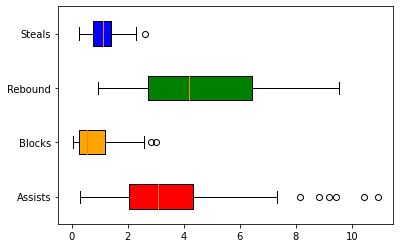

In [118]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

path="/content/drive/MyDrive/csv/seasons.csv";
df=pd.read_csv(path)

#average career span of HOF player
playerspan=df.groupby(['Player'])['Player'].count().mean()
print(playerspan)

#Box plot showing statistics min, max, average and skews
# Average point per game from player from player who score aggregate 
# points per game per season for best season
pts=df.groupby(['Player'])['PTS'].mean().round(0).astype('int')
maxPPG=pts.max()
meanPPG=pts.mean()
# max PPG
maxPPG.real
#average ppg
meanPPG.real
ppg = meanPPG / maxPPG
ppgPercent = ppg * 100

# Average DRB per game from player from player who score aggregate 
# DRB per season for best season
drb=df.groupby(['Player'])['DRB'].mean().dropna()
maxDRB=drb.max()
meanDRB=drb.mean()
# max DRB
maxDRB.real
#average DRB
meanDRB.real
drbp = meanDRB / maxDRB
drbPercent = drbp * 100
print(drbPercent)

# Average AST per game from player from player who score aggregate 
# AST per season for best season
ast=df.groupby(['Player'])['AST'].mean()
maxAST=ast.max()
meanAST=ast.mean()
# max DRB
maxAST.real
#average DRB
meanAST.real
astp = meanAST / maxAST
astPercent = astp * 100

# Average STL per game from player from player who score aggregate 
# STL per season for best season
stl=df.groupby(['Player'])['STL'].mean().dropna()
maxSTL=stl.max()
meanSTL=stl.mean()
# max DRB
maxSTL.real
meanSTL.real
stlp = meanSTL / maxSTL
stlPercent = stlp * 100

# Average BLK per game from player from player who score aggregate 
# BLK per season for best season
blk=df.groupby(['Player'])['BLK'].mean().dropna()
maxBLK=blk.max()
meanBLK=blk.mean()
# max BLK
maxBLK.real
#average BLK
meanBLK.real
blkp = meanBLK / maxBLK
blkPercent = blkp * 100

assists = ast
blocks = blk
rebounds = drb
steals = stl
 
box_plot_data=[assists,blocks,rebounds,steals]
box=plt.boxplot(box_plot_data,vert=0,patch_artist=True,labels=['Assists','Blocks','Rebound','Steals'],
            )
colors = ['red', 'orange', 'green', 'blue']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

# Radar chart showing mean assists versus maximum assists
df = pd.DataFrame(dict(
    r=[astPercent, stlPercent, blkPercent, ppgPercent, drbPercent],
    theta=['Assists','Steals','Blocks',
           'Points', 'Rebounds']))
fig = px.line_polar(df, r='r', theta='theta', line_close=True)
fig.update_traces(fill='toself')
fig.show()


# Feature Engineering

Importing

In [153]:
#tables and visualizations
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#machine learning
from sklearn.ensemble import GradientBoostingClassifier, RandomTreesEmbedding #Gradient Model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

To flesh out features for this model. I condolidated a players table from https://www.kaggle.com/code/samlow1/season-stats/data which listed season stats for every player since 1950. I used a separate list of Hall of Fame players. In the players table I added a boolean column for hall of fame status. Yes if they are in the hall, no if they're not.

There are 51 columns inclunding the class_column (HOF).

There are 24691 records overall to test and train with.

In [223]:
path="/content/drive/MyDrive/csv/seasons_stats.csv";
hof_df=pd.read_csv(path)
# dropping some columns for performance
hof_df=hof_df.drop(['Player' ,'ORB%', 'DRB%', 'TRB%', 'OWS', 'OWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'ORB%', 'DRB%', 'TRB%','AST%', 'STL%', 'MP', 'PER', 'TS%', '3PAr', 'TOV%', 'USG%', 'Age', 'PF'], axis=1)
display(hof_df.head())
hof_df.info()

,Year,HOF,Pos,Tm,G,GS,FTr,BLK%,DWS,FG,...,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PTS
0,1986.0,No,PF,LAL,82.0,1.0,0.430,1.7,2.0,209.0,...,167.0,0.611,160.0,221.0,381.0,54.0,49.0,49.0,99.0,521.0
1,1987.0,No,PF,LAL,79.0,72.0,0.480,2.0,3.3,316.0,...,282.0,0.780,210.0,405.0,615.0,84.0,70.0,80.0,102.0,852.0
2,1988.0,No,PF,LAL,82.0,64.0,0.592,1.0,3.4,322.0,...,379.0,0.773,245.0,465.0,710.0,93.0,87.0,45.0,120.0,937.0
3,1989.0,No,PF,LAL,82.0,82.0,0.474,1.2,3.5,401.0,...,359.0,0.786,258.0,481.0,739.0,103.0,94.0,55.0,119.0,1088.0
4,1990.0,No,PF,LAL,82.0,82.0,0.459,1.1,3.3,385.0,...,370.0,0.751,262.0,450.0,712.0,90.0,66.0,50.0,116.0,1061.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24691 entries, 0 to 24690
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    24624 non-null  float64
 1   HOF     24679 non-null  object 
 2   Pos     24624 non-null  object 
 3   Tm      24624 non-null  object 
 4   G       24624 non-null  float64
 5   GS      18234 non-null  float64
 6   FTr     24525 non-null  float64
 7   BLK%    20792 non-null  float64
 8   DWS     24585 non-null  float64
 9   FG      24624 non-null  float64
 10  FGA     24624 non-null  float64
 11  FG%     24525 non-null  float64
 12  3P      18928 non-null  float64
 13  3PA     18928 non-null  float64
 14  3P%     15417 non-null  float64
 15  2P      24624 non-null  float64
 16  2PA     24624 non-null  float64
 17  2P%     24496 non-null  float64
 18  eFG%    24525 non-null  float64
 19  FT      24624 non-null  float64
 20  FTA     24624 non-null  float64
 21  FT%     23766 non-null  float64
 22

In [224]:
hof_df.isna().sum()

Year      67
HOF       12
Pos       67
Tm        67
G         67
GS      6457
FTr      166
BLK%    3899
DWS      106
FG        67
FGA       67
FG%      166
3P      5763
3PA     5763
3P%     9274
2P        67
2PA       67
2P%      195
eFG%     166
FT        67
FTA       67
FT%      925
ORB     3894
DRB     3894
TRB      379
AST       67
STL     3894
BLK     3894
TOV     5045
PTS       67
dtype: int64

# Data Cleaning and EDA

In [225]:
hof_df = hof_df.dropna(subset=['HOF'])
hof_df.shape

(24679, 30)

In [226]:
class_column = 'HOF'
random_seed = 1000

X_train, X_test, y_train, y_test = train_test_split(hof_df.drop(columns=class_column), hof_df[class_column],
                                                   test_size=0.20, random_state=random_seed, stratify=hof_df[class_column])

# Sanity Check

In [227]:
# X Train
print('On X train: ')
print('X train dimensions: ', X_train.shape)
display(X_train.head())

# X test
print('\nOn X test: ')
print('X test dimensions: ', X_test.shape)
display(X_test.head())

On X train: 
X train dimensions:  (19743, 29)


,Year,Pos,Tm,G,GS,FTr,BLK%,DWS,FG,FGA,...,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PTS
7696,1985.0,C,NYK,54.0,16.0,0.524,1.1,1.0,116.0,233.0,...,122.0,0.541,86.0,176.0,262.0,16.0,21.0,16.0,64.0,298.0
15847,2015.0,SG,TOT,48.0,0.0,0.162,0.8,0.7,140.0,345.0,...,56.0,0.821,23.0,63.0,86.0,36.0,27.0,7.0,27.0,380.0
19403,1999.0,SG,MIN,27.0,1.0,0.704,1.3,0.3,15.0,54.0,...,38.0,0.553,27.0,32.0,59.0,41.0,12.0,5.0,14.0,51.0
19231,1954.0,C,BLB,72.0,NaN,0.716,NaN,1.0,410.0,983.0,...,704.0,0.638,NaN,NaN,958.0,82.0,NaN,NaN,NaN,1269.0
6991,1954.0,SG,MLH,68.0,NaN,0.451,NaN,1.7,254.0,748.0,...,337.0,0.748,NaN,NaN,225.0,187.0,NaN,NaN,NaN,760.0



On X test: 
X test dimensions:  (4936, 29)


,Year,Pos,Tm,G,GS,FTr,BLK%,DWS,FG,FGA,...,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PTS
4240,2001.0,SF,GSW,20.0,8.0,0.264,1.9,0.2,36.0,106.0,...,28.0,0.857,10.0,31.0,41.0,19.0,16.0,10.0,19.0,115.0
5041,2005.0,SG,MEM,52.0,7.0,0.337,1.3,0.6,83.0,190.0,...,64.0,0.688,11.0,58.0,69.0,21.0,13.0,11.0,29.0,233.0
5746,1988.0,SG,PHI,22.0,1.0,0.405,0.9,0.2,47.0,116.0,...,47.0,0.681,11.0,24.0,35.0,34.0,12.0,5.0,40.0,126.0
9057,1990.0,PG,DET,46.0,0.0,0.157,0.4,0.4,42.0,83.0,...,13.0,0.769,8.0,23.0,31.0,61.0,8.0,2.0,16.0,108.0
8085,2004.0,PG,PHI,82.0,82.0,0.442,0.2,2.3,295.0,715.0,...,316.0,0.797,62.0,219.0,281.0,563.0,97.0,6.0,187.0,844.0


In [228]:
# X Train
print('On y train: ')
print('y train dimensions: ', y_train.shape)
display(y_train.head())

# X test
print('\nOn y test: ')
print('y test dimensions: ', y_test.shape)
display(y_test.head())

On y train: 
y train dimensions:  (19743,)


7696     No
15847    No
19403    No
19231    No
6991     No
Name: HOF, dtype: object


On y test: 
y test dimensions:  (4936,)


4240    Yes
5041     No
5746     No
9057     No
8085     No
Name: HOF, dtype: object

# Initial Pipeline

Establish pipline for data types

In [229]:
cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                               ('onehot_cat', OneHotEncoder(handle_unknown='ignore'))])
num_pipeline = Pipeline(steps=[('impute_num', SimpleImputer(strategy='mean')),
                               ('scale_num', StandardScaler())])

Initialize preprocessing pipeline by feature set

In [230]:
preprocess = ColumnTransformer([('cat_pipe', cat_pipeline, make_column_selector(dtype_include=object)),
                             ('num_pipe', num_pipeline, make_column_selector(dtype_include=np.number))],
                             remainder='passthrough')

print(preprocess)

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat_pipe',
                                 Pipeline(steps=[('cat_impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot_cat',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fba4512dc50>),
                                ('num_pipe',
                                 Pipeline(steps=[('impute_num',
                                                  SimpleImputer()),
                                                 ('scale_num',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fba4512dd50>)])


LogisticRegression

In [231]:
pipeLR = Pipeline(steps=[('preproc', preprocess),
                       ('mdl', LogisticRegression(penalty='elasticnet', solver='saga', tol=0.01))])

with config_context(display='diagram'):
    display(pipeLR)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fba4512dc50>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fba4512dd50>)])),
                ('mdl',
                 LogisticRegression(penalty='elasticnet', solver='saga',
                                    tol=0.01))])

GradientBoost

In [232]:
# TODO: set up your modeling pipeline GradientBoosting
pipeGradBoost = Pipeline(steps=[('preproc', preprocess),
                       ('gbc', GradientBoostingClassifier())])


# Feel free to uncomment and edit the code below to visualize your overall pipeline
with config_context(display='diagram'):
    display(pipeGradBoost)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fba4512dc50>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fba4512dd50>)])),
                ('gbc', GradientBoostingClassifier())])

RandomForest

In [233]:
# TODO: set up your modeling pipeline RandomForest
pipeRandForest = Pipeline([('preproc', preprocess),
                        ('rf', RandomForestClassifier())])

# Feel free to uncomment and edit the code below to visualize your overall pipeline
with config_context(display='diagram'):
    display(pipeRandForest)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fba4512dc50>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fba4512dd50>)])),
                ('rf', RandomForestClassifier())])

# Cross-validation with hyperparameter tuning

LogisticalRegression

In [234]:
# TODO: set up your tuning grid 
# grid_search_lr.get_params().keys()
tuning_grid_lr = {'mdl__l1_ratio' : np.linspace(0,1,5),
                           'mdl__C': np.logspace(-1, 6, 3) }
grid_search_lr = GridSearchCV(pipeLR, param_grid = tuning_grid_lr, cv = 5, return_train_score=True)

print(grid_search_lr)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fba4512dc50>),
                                                                        ('num_pipe',
                                             

RandomForest

In [235]:
# TODO: set up your tuning grid
# grid_search_rf.get_params().keys()
tuning_grid_rf = param_grid = {'rf__n_estimators': [10, 50],
                                        'rf__max_features': ['auto', 'sqrt', 'log2'],
                                        'rf__max_depth' : [4,5,6],
                                        'rf__criterion' :['gini', 'entropy']
                                       }
grid_search_rf = GridSearchCV(pipeRandForest, param_grid = tuning_grid_rf, cv = 5, return_train_score=True)

GradientBoost

In [236]:
# TODO: set up your tuning grid
# grid_search_gb.get_params().keys()
tuning_grid_gb = param_grid = {'gbc__learning_rate': [1, 0.5, 0.25],
                                       'gbc__n_estimators': [64, 128, 256],
                                       'gbc__max_depth': [2, 4],
                                       'gbc__min_samples_split': [2, 4]
                                      }
grid_search_gb = GridSearchCV(pipeGradBoost, param_grid = tuning_grid_gb, cv = 5, return_train_score=True)

# Fitting

In [237]:
# Fit Logistic
grid_search_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fba4512dc50>),
                                                                        ('num_pipe',
                                             

In [260]:
# Fit Gradient (Warning: takes forever!)
#grid_search_gb.fit(X_train, y_train)

In [240]:
# Fit RandomForest
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fba4512dc50>),
                                                                        ('num_pipe',
                                             

# Best Performing Model Parameters

LogisticalRegression

In [242]:
print("LogisticRegression best score:", grid_search_lr.best_score_)
grid_search_lr.best_params_

LogisticRegression best score: 0.9432708779594335


{'mdl__C': 1000000.0, 'mdl__l1_ratio': 0.25}

RandomForest

In [243]:
print("RandomForest best score:", grid_search_rf.best_score_)
grid_search_rf.best_params_

RandomForest best score: 0.9400799017257263


{'rf__criterion': 'entropy',
 'rf__max_depth': 6,
 'rf__max_features': 'auto',
 'rf__n_estimators': 50}

GradientBoost

In [ ]:
print("GradientBoost best score:", grid_search_gb.best_score_)
grid_search_gb.best_params_

# Final Fit

LogisticalRegression

In [244]:
grid_search_lr.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb99d836e90>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                         

RandomForest

In [245]:
grid_search_rf.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fba45d5fb50>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                         

GradientBoost

In [ ]:
grid_search_gb.best_estimator_

# Variable Importance

LogisticalRegression

In [246]:
grid_search_lr.classes_

array(['No', 'Yes'], dtype=object)

In [247]:
vip_lr = grid_search_lr.best_estimator_['mdl'].coef_[0]
print(grid_search_lr.best_estimator_['mdl'].coef_[0])
vip_lr

[-2.38490033e+00 -1.20858125e-01 -5.46432218e-02 -5.21217345e-03
 -4.18440094e-01 -3.41467153e-01 -3.00095004e-01 -5.47917273e-01
 -3.67668630e-01 -2.83652542e+00 -5.04232806e-02 -4.53017488e-02
 -2.48232246e+00 -5.92171176e-03 -5.74841988e-02 -2.37642756e+00
 -5.30157981e-02 -3.51204039e-03 -5.24232024e-02 -2.31779838e+00
 -1.45036014e-02 -2.81203220e-02 -4.89141603e-02 -1.27863640e-01
 -5.99900674e-01 -2.20365454e-01 -2.13228667e-01  5.87246620e-01
 -4.32166724e-02 -1.86827572e-01 -1.32101309e-02 -1.80682393e-01
 -2.67675509e-01 -4.84268342e-01 -5.94466079e-02 -1.65745503e-02
 -5.94323535e-02  3.93451042e-03 -8.23256122e-02 -8.99602898e-01
 -4.85446945e-01 -3.54954964e-01 -2.86598859e-01 -6.98256887e-02
 -2.33133421e-01 -3.69964598e-01  1.05553844e-01 -4.06398833e-01
 -2.10770827e-01 -3.31564488e-01 -5.60393176e-02 -5.57737720e-01
  2.30263294e-01 -3.04088951e-01 -3.35143241e-01 -5.39461070e-01
 -3.29692333e-01 -9.18523585e-02  1.90681748e-02 -4.86991917e-01
 -1.93691611e-01 -2.29472

array([-2.38490033e+00, -1.20858125e-01, -5.46432218e-02, -5.21217345e-03,
       -4.18440094e-01, -3.41467153e-01, -3.00095004e-01, -5.47917273e-01,
       -3.67668630e-01, -2.83652542e+00, -5.04232806e-02, -4.53017488e-02,
       -2.48232246e+00, -5.92171176e-03, -5.74841988e-02, -2.37642756e+00,
       -5.30157981e-02, -3.51204039e-03, -5.24232024e-02, -2.31779838e+00,
       -1.45036014e-02, -2.81203220e-02, -4.89141603e-02, -1.27863640e-01,
       -5.99900674e-01, -2.20365454e-01, -2.13228667e-01,  5.87246620e-01,
       -4.32166724e-02, -1.86827572e-01, -1.32101309e-02, -1.80682393e-01,
       -2.67675509e-01, -4.84268342e-01, -5.94466079e-02, -1.65745503e-02,
       -5.94323535e-02,  3.93451042e-03, -8.23256122e-02, -8.99602898e-01,
       -4.85446945e-01, -3.54954964e-01, -2.86598859e-01, -6.98256887e-02,
       -2.33133421e-01, -3.69964598e-01,  1.05553844e-01, -4.06398833e-01,
       -2.10770827e-01, -3.31564488e-01, -5.60393176e-02, -5.57737720e-01,
        2.30263294e-01, -

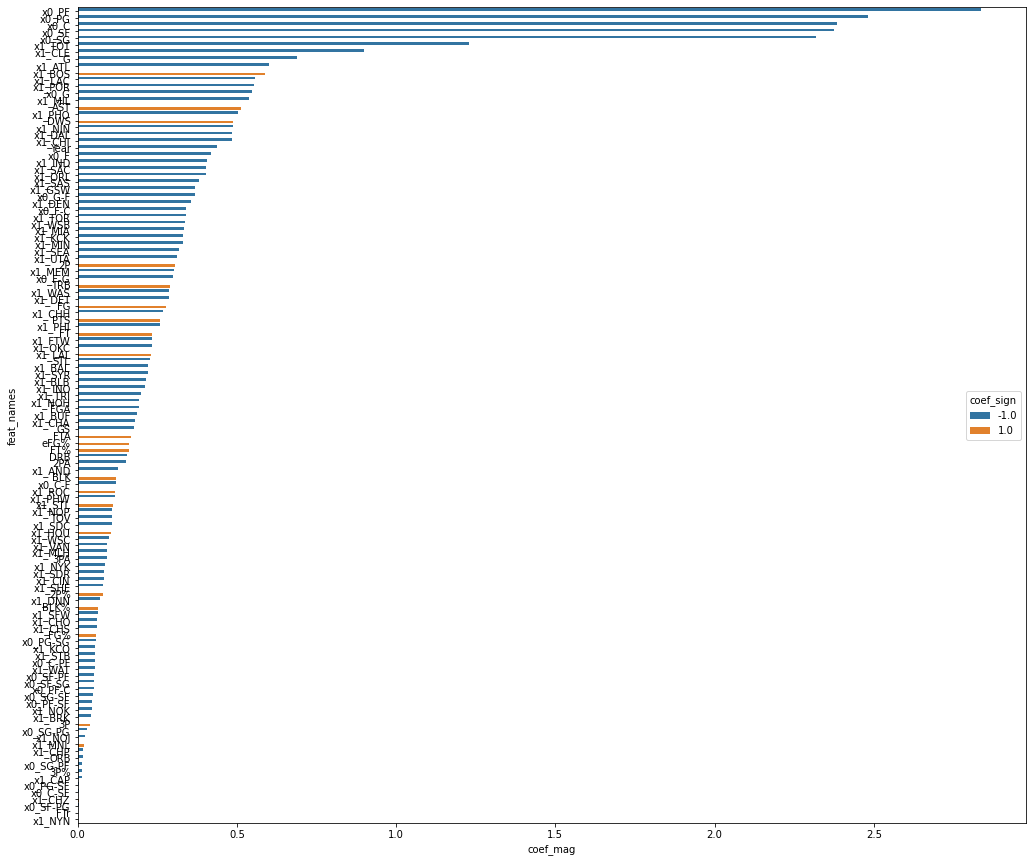

In [253]:

#get names in correct preproc order
cat_names = grid_search_lr.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names_out()
num_names = grid_search_lr.best_estimator_.named_steps['preproc'].transformers_[1][2]
#create df with vip info
coef_info = pd.DataFrame({'feat_names':np.hstack([cat_names, num_names]), 'vip': vip_lr})

#get sign and magnitude information
coef_info = coef_info.assign(coef_mag = abs(coef_info['vip']),
                             coef_sign = np.sign(coef_info['vip']))

#sort and plot
coef_info = coef_info.set_index('feat_names').sort_values(by='coef_mag', ascending=False)
plt.figure(figsize = (17,15))
sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=True)

Random Forest

In [172]:
grid_search_rf.classes_

array(['No', 'Yes'], dtype=object)

In [173]:
vip_rf = grid_search_rf.best_estimator_['rf']
vip_rf

print(grid_search_rf)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fba4bba3a50>),
                                                                        ('num_pipe',
                                             

In [254]:
# TODO: feel free to uncomment and edit the code below to obtain your feature importance graph. 
# Did the graph surprise you? What features did you think were more important?


#get names in correct preproc order
cat_names = grid_search_rf.best_estimator_.named_steps['preproc'].transformers_[0][1]
num_names = grid_search_rf.best_estimator_.named_steps['preproc'].transformers_[1][2]

#create df with vip info
#print(cat_names)
#print(num_names)

#coef_info = pd.DataFrame({'feat_names':np.hstack([cat_names, num_names]), 'vip': vip_rf})

#get sign and magnitude information
#coef_info = coef_info.assign(coef_mag = abs(coef_info['vip']),
                             #coef_sign = np.sign(coef_info['vip']))

#sort and plot
#coef_info = coef_info.set_index('feat_names').sort_values(by='coef_mag', ascending=False)
#plt.figure(figsize = (17,15))
#sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=False)

GradientBoost

In [ ]:
grid_search_gb.classes_

In [259]:
#vip_gb = grid_search_gb.best_estimator_['gb']
#vip_gb

#print(grid_search_gb)

In [ ]:
# TODO: feel free to uncomment and edit the code below to obtain your feature importance graph. 
# Did the graph surprise you? What features did you think were more important?


#get names in correct preproc order
cat_names = grid_search_gb.best_estimator_.named_steps['preproc'].transformers_[0][1]
num_names = grid_search_gb.best_estimator_.named_steps['preproc'].transformers_[1][2]

#create df with vip info
#print(cat_names)
#print(num_names)

coef_info = pd.DataFrame({'feat_names':np.hstack([cat_names, num_names]), 'vip': vip_gb})

#get sign and magnitude information
#coef_info = coef_info.assign(coef_mag = abs(coef_info['vip']),
                             #coef_sign = np.sign(coef_info['vip']))

#sort and plot
#coef_info = coef_info.set_index('feat_names').sort_values(by='coef_mag', ascending=False)
#plt.figure(figsize = (17,15))
#sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=False)

# Performance metrics on test data

In [256]:
print(classification_report(y_test, grid_search_lr.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

          No       0.95      0.99      0.97      4566
         Yes       0.71      0.39      0.50       370

    accuracy                           0.94      4936
   macro avg       0.83      0.69      0.74      4936
weighted avg       0.93      0.94      0.93      4936



Confusion Matrix

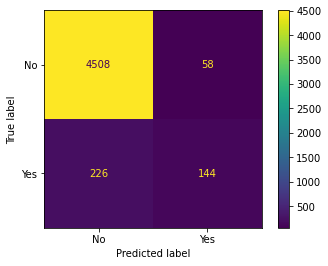

In [257]:
# TODO: plot the confusion matrix graph
confMatrix_lr = confusion_matrix(y_test, grid_search_lr.best_estimator_.predict(X_test))
confMatrixDisplay = ConfusionMatrixDisplay(confusion_matrix=confMatrix_lr, 
                                           display_labels=grid_search_lr.classes_)
confMatrixDisplay.plot()
plt.show()

Accuracy

In [258]:
#     TP+TN/
#   TP+TN+FP+FN
numerator = 202+5650
denominator = 202+5650+261+57

accuracy = numerator/denominator
format_float = "{:.2f}".format(accuracy*100)
print('Accurancy', format_float,'%')

Accurancy 94.85 %
